<a href="https://colab.research.google.com/github/lucywowen/csci547_ML/blob/main/examples/Coffee_roasting_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple Neural Network

## Coffee roasting example

> In this hackathon, we're going to build a small neural network using Numpy.  Then we'll see how the to implement it in Scikit-learn and Keras.

First lets import the libraries

In [1]:
!pip install keras

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.neural_network
import matplotlib.colors as colors
from matplotlib import cm
import keras
from keras.layers import Dense, Input, Normalization
from keras.models import Sequential
from keras.activations import sigmoid
import matplotlib.colors as colors
from matplotlib import cm

And define some helper functions (these are mainly to do with plotting and data generation)

In [3]:
def load_coffee_data():
    rng = np.random.default_rng(2) # Define the seed from random number generator
    X = rng.random(400).reshape(-1,2) # Generate 400 values between 0 and 1 and reshape to matrix 200 x 2
    X[:,1] = X[:,1] * 4 + 11.5          # Feature 1 will be time: 12-15 min is best
    X[:,0] = X[:,0] * (285-150) + 150  # Feature 1 will be temperature: 350-500 F (175-260 C) is best
    Y = np.zeros(len(X)) # initialize a matrix of 0s for Ys

    i=0
    for t,d in X:
        y = -3/(260-175)*t + 21 # calculate the ideal duration based on the temperature
        if (t > 175 and t < 260 and d > 12 and d < 15 and d<=y ): # if temperature falls between 175 and 160, and the duration falls between ideal duration and 15, set y = 1
            Y[i] = 1
        else:
            Y[i] = 0
        i += 1

    return (X, Y.reshape(-1,1))

def plt_prob(ax,fwb):
  """ plots a decision boundary but include shading to indicate the probability """
  #setup useful ranges and common linspaces
  x0_space  = np.linspace(150, 285 , 40)
  x1_space  = np.linspace(11.5, 15.5 , 40)
  # get probability for x0,x1 ranges
  tmp_x0,tmp_x1 = np.meshgrid(x0_space,x1_space)
  z = np.zeros_like(tmp_x0)
  for i in range(tmp_x0.shape[0]):
      for j in range(tmp_x1.shape[1]):
          x = np.array([[tmp_x0[i,j],tmp_x1[i,j]]])
          z[i,j] = fwb(x)


  cmap = plt.get_cmap('Blues')
  new_cmap = truncate_colormap(cmap, 0.0, 0.5)
  pcm = ax.pcolormesh(tmp_x0, tmp_x1, z, norm=cm.colors.Normalize(vmin=0, vmax=1), cmap=new_cmap, shading='nearest', alpha = 0.9)
  ax.figure.colorbar(pcm, ax=ax)

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
  """ truncates color map """
  new_cmap = colors.LinearSegmentedColormap.from_list('trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
                                                      cmap(np.linspace(minval, maxval, n)))
  return new_cmap

dlc = dict(dlblue = '#0096ff', dlorange = '#FF9300', dldarkred='#C00000', dlmagenta='#FF40FF', dlpurple='#7030A0', dldarkblue =  '#0D5BDC')
def plotData(X, Y):
    Y = Y.reshape(-1,)
    colormap = np.array(['r', 'b'])
    fig, ax = plt.subplots(1,1,)
    ax.scatter(X[Y==1,0],X[Y==1,1], s=70, marker='x', c='red', label="Good Roast" )
    ax.scatter(X[Y==0,0],X[Y==0,1], s=100, marker='o', facecolors='none',
                   edgecolors=dlc["dldarkblue"],linewidth=1,  label="Bad Roast")
    tr = np.linspace(175,260,50)
    ax.plot(tr, (-3/85) * tr + 21, color=dlc["dlpurple"],linewidth=1)
    ax.axhline(y=12,color=dlc["dlpurple"],linewidth=1)
    ax.axvline(x=175,color=dlc["dlpurple"],linewidth=1)
    ax.set_title(f"Coffee Roasting", size=16)
    ax.set_xlabel("Temperature \n(Celsius)",size=12)
    ax.set_ylabel("Duration \n(minutes)",size=12)
    ax.legend(loc='upper right')
    plt.show()

def plt_network(X,Y,netf):
  fig, ax = plt.subplots(1,2,figsize=(16,4))
  Y = Y.reshape(-1,)
  plt_prob(ax[0], netf)
  ax[0].scatter(X[Y==1,0],X[Y==1,1], s=70, marker='x', c='red', label="Good Roast" )
  ax[0].scatter(X[Y==0,0],X[Y==0,1], s=100, marker='o', facecolors='none',
                edgecolors=dlc["dldarkblue"],linewidth=1,  label="Bad Roast")
  ax[0].plot(X[:,0], (-3/85) * X[:,0] + 21, color=dlc["dlpurple"],linewidth=1)
  ax[0].axhline(y= 12, color=dlc["dlpurple"], linewidth=1)
  ax[0].axvline(x=175, color=dlc["dlpurple"], linewidth=1)
  ax[0].set_xlabel("Temperature \n(Celsius)",size=12)
  ax[0].set_ylabel("Duration \n(minutes)",size=12)
  ax[0].legend(loc='upper right')
  ax[0].set_title(f"network probability")

  ax[1].plot(X[:,0], (-3/85) * X[:,0] + 21, color=dlc["dlpurple"],linewidth=1)
  ax[1].axhline(y= 12, color=dlc["dlpurple"], linewidth=1)
  ax[1].axvline(x=175, color=dlc["dlpurple"], linewidth=1)
  fwb = netf(X)
  yhat = (fwb > 0.5).astype(int)
  ax[1].scatter(X[yhat[:,0]==1,0],X[yhat[:,0]==1,1], s=70, marker='x', c='orange', label="Predicted Good Roast" )
  ax[1].scatter(X[yhat[:,0]==0,0],X[yhat[:,0]==0,1], s=100, marker='o', facecolors='none',
                edgecolors=dlc["dldarkblue"],linewidth=1,  label="Bad Roast")
  ax[1].set_title(f"network decision")
  ax[1].set_xlabel("Temperature \n(Celsius)",size=12)
  ax[1].set_ylabel("Duration \n(minutes)",size=12)
  ax[1].legend(loc='upper right')


def plt_output_unit(W,b):
  """ plots a single unit function with 3 inputs """
  steps = 10
  fig = plt.figure()
  ax = fig.add_subplot(projection='3d')
  x_ = np.linspace(0., 1., steps)
  y_ = np.linspace(0., 1., steps)
  z_ = np.linspace(0., 1., steps)
  x, y, z = np.meshgrid(x_, y_, z_, indexing='ij')
  d = np.zeros((steps,steps,steps))
  cmap = plt.get_cmap('Blues')
  for i in range(steps):
    for j in range(steps):
      for k in range(steps):
          v = np.array([x[i,j,k],y[i,j,k],z[i,j,k]])
          d[i,j,k] = keras.activations.sigmoid(np.dot(v,W[:,0])+b).numpy()
  pcm = ax.scatter(x, y, z, c=d, cmap=cmap, alpha = 1 )
  ax.set_xlabel("unit 0");
  ax.set_ylabel("unit 1");
  ax.set_zlabel("unit 2");
  ax.view_init(30, -120)
  ax.figure.colorbar(pcm, ax=ax)
  ax.set_title(f"Layer 2, output unit")
  plt.show()

def plt_layer(X,Y,W1,b1,norm_l):
  Y = Y.reshape(-1,)
  fig,ax = plt.subplots(1,W1.shape[1], figsize=(16,4))
  for i in range(W1.shape[1]):
    layerf= lambda x : sigmoid(np.dot(norm_l(x),W1[:,i]) + b1[i])
    plt_prob(ax[i], layerf)
    ax[i].scatter(X[Y==1,0],X[Y==1,1], s=70, marker='x', c='red', label="Good Roast" )
    ax[i].scatter(X[Y==0,0],X[Y==0,1], s=100, marker='o', facecolors='none',
                  edgecolors=dlc["dldarkblue"],linewidth=1,  label="Bad Roast")
    tr = np.linspace(175,260,50)
    ax[i].plot(tr, (-3/85) * tr + 21, color=dlc["dlpurple"],linewidth=2)
    ax[i].axhline(y= 12, color=dlc["dlpurple"], linewidth=2)
    ax[i].axvline(x=175, color=dlc["dlpurple"], linewidth=2)
    ax[i].set_title(f"Layer 1, unit {i}")
    ax[i].set_xlabel("Temperature \n(Celsius)",size=12)
  ax[0].set_ylabel("Duration \n(minutes)",size=12)
  plt.show()


And lets simulate some data:

In [4]:
X, Y = load_coffee_data();

## Plot the data
> Let's plot the coffee roasting data below. The two features are Temperature in Celsius and Duration in minutes. [Coffee Roasting at Home](https://www.merchantsofgreencoffee.com/how-to-roast-green-coffee-in-your-oven/) suggests that the duration is best kept between 12 and 15 minutes while the temp should be between 175 and 260 degrees Celsius. Of course, as temperature rises, the duration should shrink.

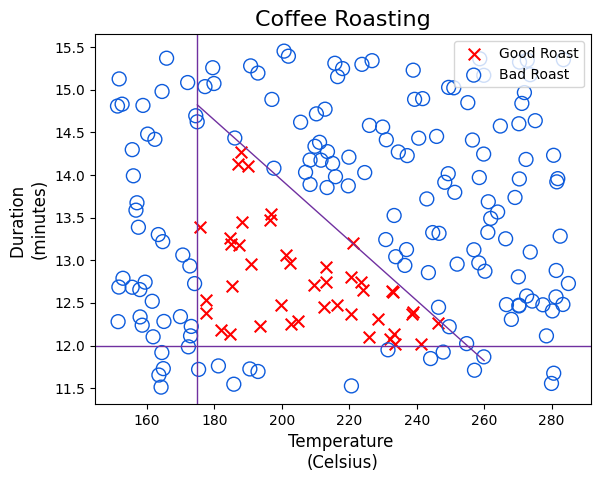

In [5]:
plotData(X, Y)

## Normalize Data
> Fitting the weights to the data (back-propagation, covered in Thursday's lecture) will proceed more quickly if the data is normalized. This is the same procedure you've seen before where features in the data are each normalized to have a similar range. The procedure below uses a Keras normalization layer. It has the following steps:

- create a "Normalization Layer". Note, as applied here, this is not a layer in your model.
- 'adapt' the data. This learns the mean and variance of the data set and saves the values internally.
- normalize the data.
It is important to apply normalization to any future data that utilizes the learned model.

In [6]:
print(f"Temperature Max, Min pre normalization: {np.max(X[:,0]):0.2f}, {np.min(X[:,0]):0.2f}")
print(f"Duration    Max, Min pre normalization: {np.max(X[:,1]):0.2f}, {np.min(X[:,1]):0.2f}")
norm_l = Normalization(axis=-1)
norm_l.adapt(X)  # learns mean, variance
Xn = norm_l(X)
print(f"Temperature Max, Min post normalization: {np.max(Xn[:,0]):0.2f}, {np.min(Xn[:,0]):0.2f}")
print(f"Duration    Max, Min post normalization: {np.max(Xn[:,1]):0.2f}, {np.min(Xn[:,1]):0.2f}")

Temperature Max, Min pre normalization: 284.99, 151.32
Duration    Max, Min pre normalization: 15.45, 11.51
Temperature Max, Min post normalization: 1.66, -1.69
Duration    Max, Min post normalization: 1.79, -1.70


## Build the Numpy neural network
> Let's build the "Coffee Roasting Network" described in lecture. There are two layers with sigmoid activations.
>As described in lecture, it is possible to build your own dense layer using NumPy. This can then be utilized to build a multi-layer neural network.

First, you will define the activation function `g()`. You will use the function `sigmoid()`

In [7]:
def sigmoid(z):
  """

  Compute the sigmoid of z

  Parameters
  ----------
  z : array_like
      A scalar or numpy array of any size.

  Returns
  -------
  g : array_like
      sigmoid(z)
  """
  z = np.clip( z, -500, 500 )           # protect against overflow
  g = 1.0/(1.0+np.exp(-z))
  return g


In [8]:
# Define the activation function
g = sigmoid

> As described in the leacture, it is possible to build your own dense layer using NumPy. This can then be utilised to build a multi-layer neural network.
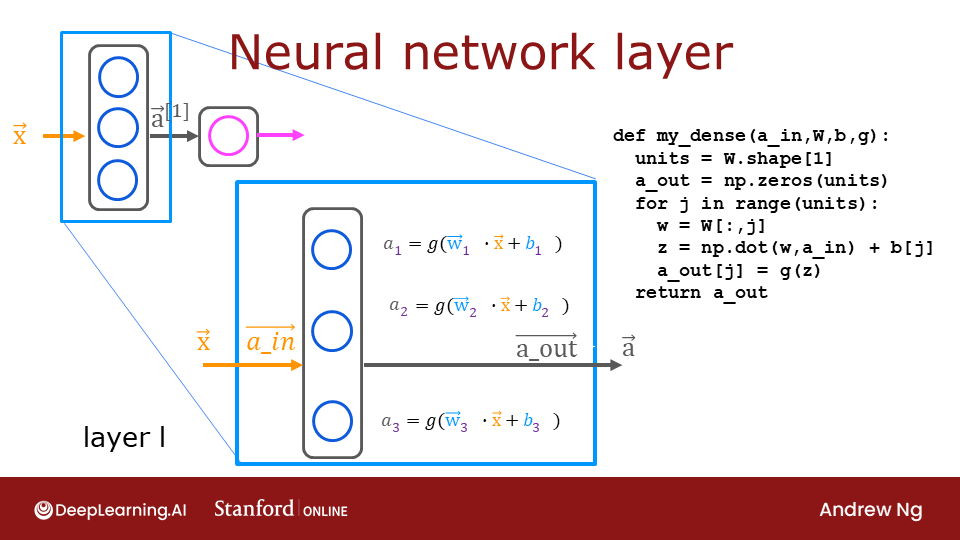


> Below, build a dense layer subroutine. The example in lecture utilized a for loop to visit each unit (j) in the layer and perform the dot product of the weights for that unit (W[:,j]) and sum the bias for the unit (b[j]) to form z. An activation function g(z) is then applied to that result. This section will not utilize some of the matrix operations described in the optional lectures. These will be explored in a later section.

In [9]:
def my_dense(a_in, W, b, g):
    """
    Computes dense layer
    Args:
      a_in (ndarray (n, )) : Data, 1 example
      W    (ndarray (n,j)) : Weight matrix, n features per unit, j units
      b    (ndarray (j, )) : bias vector, j units
      g    activation function (e.g. sigmoid, relu..)
    Returns
      a_out (ndarray (j,))  : j units
    """
    units = W.shape[1]
    a_out = np.zeros(units)
### START CODE HERE ###


### END CODE HERE ###
    return(a_out)

In [10]:
X.shape

(200, 2)

In [11]:
# Quick Check
x_tst = 0.1*np.arange(1,3,1).reshape(2,)  # (1 examples, 2 features)
W_tst = 0.1*np.arange(1,7,1).reshape(2,3) # (2 input features, 3 output features)
b_tst = 0.1*np.arange(1,4,1).reshape(3,)  # (3 features)
A_tst = my_dense(x_tst, W_tst, b_tst, sigmoid)
print(A_tst)

[0.54735762 0.57932425 0.61063923]


Expected Output

[0.54735762 0.57932425 0.61063923]

### Bonus problem: Vectorized NumPy Model Implementation
> We talked in our lecture about vector and matrix operations that can be used to speed the calculations. Below describes a layer operation that computer the output for all units in a layer on a given input example:

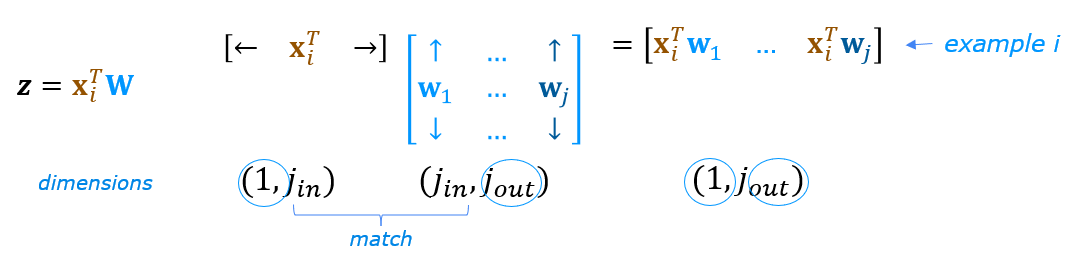


>We can demonstrate this using the examples X and the W_tst,b_tst parameters above. We use np.matmul to perform the matrix multiply. Note, the dimensions of X and W must be compatible as shown in the diagram above.


In [12]:
z1 = np.matmul(X,W_tst) + b_tst    # (200,2)(2,3) = (1,3)
a1 = sigmoid(z1)
print(a1.shape)

(200, 3)


> You can take this a step further and compute all the units for all examples in one Matrix-Matrix operation.
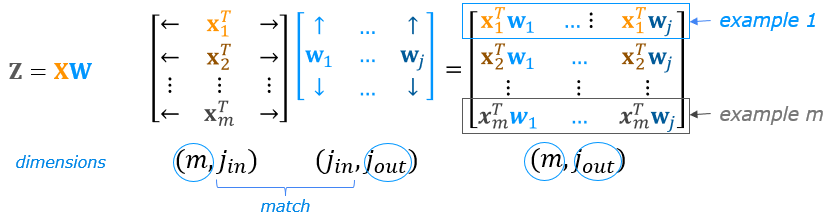

> The full operation is Z=XW+b. This will utilize NumPy broadcasting to expand
 to rows.

> Compose a new `my_dense_v` subroutine that performs the layer calculations for a matrix of examples. This will utilize `np.matmul()`.

In [13]:

def my_dense_v(A_in, W, b, g):
    """
    Computes dense layer
    Args:
      A_in (ndarray (m,n)) : Data, m examples, n features each
      W    (ndarray (n,j)) : Weight matrix, n features per unit, j units
      b    (ndarray (1,j)) : bias vector, j units
      g    activation function (e.g. sigmoid, relu..)
    Returns
      A_out ( ndarray (m,j)) : m examples, j units
    """
### START CODE HERE ###

### END CODE HERE ###
    return(A_out)

In [14]:
# Quick Check
x_tst = 0.1*np.arange(1,3,1).reshape(2,)  # (1 examples, 2 features)
W_tst = 0.1*np.arange(1,7,1).reshape(2,3) # (2 input features, 3 output features)
b_tst = 0.1*np.arange(1,4,1).reshape(3,)  # (3 features)
A_tst = my_dense_v(x_tst, W_tst, b_tst, sigmoid)
print(A_tst)

[0.54735762 0.57932425 0.61063923]


Expected Output

[0.54735762 0.57932425 0.61063923]

The following cell builds a two-layer neural network utilizing the my_dense subroutine above.

In [15]:
def my_sequential(x, W1, b1, W2, b2, g):
    a1 = my_dense(x,  W1, b1, g)
    a2 = my_dense(a1, W2, b2, g)
    return(a2)

These are a few of the trained weights and biases that we'll see come from the next part of the lab (implementing this is Keras).

In [16]:
W1_tmp = np.array( [[-8.93,  0.29, 12.9 ], [-0.1,  -7.32, 10.81]] )
b1_tmp = np.array( [-9.82, -9.28,  0.96] )
W2_tmp = np.array( [[-31.18], [-27.59], [-32.56]] )
b2_tmp = np.array( [15.41] )

## Predictions
> Once you have a trained model, you can then use it to make predictions. Recall that the output of our model is a probability. In this case, the probability of a good roast. To make a decision, one must apply the probability to a threshold. In this case, we will use 0.5

> Let's start by writing a `predict` function. This will take a matrix
 with all examples in the rows and make a prediction by running the model.

In [17]:
def my_predict(X, W1, b1, W2, b2, g):
    m = X.shape[0]
    p = np.zeros((m,1))
    for i in range(m):
        p[i,0] = my_sequential(X[i], W1, b1, W2, b2, g)
    return(p)

We can try this routine on two examples:

In [18]:
X_tst = np.array([
    [200,13.9],  # postive example
    [200,17]])   # negative example
X_tstn = norm_l(X_tst)  # remember to normalize
predictions = my_predict(X_tstn, W1_tmp, b1_tmp, W2_tmp, b2_tmp, g)

<ipython-input-17-834ef03eca99>:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p[i,0] = my_sequential(X[i], W1, b1, W2, b2, g)


To convert the probabilities to a decision, we apply a threshold:

In [19]:
yhat = np.zeros_like(predictions)
for i in range(len(predictions)):
    if predictions[i] >= 0.5:
        yhat[i] = 1
    else:
        yhat[i] = 0
print(f"decisions = \n{yhat}")

decisions = 
[[1.]
 [0.]]


This can be accomplished more succinctly:

In [20]:
yhat = (predictions >= 0.5).astype(int)
print(f"decisions = \n{yhat}")

decisions = 
[[1]
 [0]]


> Great job!  Now lets do a couple of practice

## Keras implementation
> Ok now let's see how we can do all of that using this framework in Keras.  So we've already normalized the data... so lets start by tiling (copying) our data to increase the training set size and reduce the number of training epochs.  
Note: this could be accomplished by just running the simulation code and creating a larger dataset from the beginning!  

In [21]:
Xt = np.tile(Xn,(1000,1))
Yt= np.tile(Y,(1000,1))
print(Xt.shape, Yt.shape)

(200000, 2) (200000, 1)


## Keras model
Let's build the same "Coffee Roasting Network" described in lecture. There are two layers with sigmoid activations: 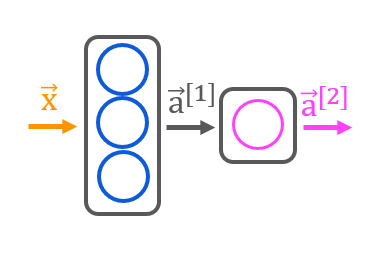

In [22]:
keras.utils.set_random_seed(1234)

model = Sequential(
    [
        Input(shape=(2,)),
        Dense(3, activation='sigmoid', name = 'layer1'),
        Dense(1, activation='sigmoid', name = 'layer2')
     ]
)

> Note 1: The Input(shape=(2,)), specifies the expected shape of the input. This allows Keras to size the weights and bias parameters at this point. This is useful when exploring Keras models. This statement can be omitted in practice and Keras will size the network parameters when the input data is specified in the model.fit statement.

>Note 2: Including the sigmoid activation in the final layer is not considered best practice. It would instead be accounted for in the loss which improves numerical stability. This will be described in more detail in a later lab.

The `model.summary()` method provides a description of the network:

In [23]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ layer1 (Dense)                       │ (None, 3)                   │               9 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer2 (Dense)                       │ (None, 1)                   │               4 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13 (52.00 B)

 Trainable params: 13 (52.00 B)

 Non-trainable params: 0 (0.00 B)

The parameter counts shown in the summary correspond to the number of elements in the weight and bias arrays as shown below.

In [24]:
L1_num_params = 2 * 3 + 3   # W1 parameters  + b1 parameters
L2_num_params = 3 * 1 + 1   # W2 parameters  + b2 parameters
print("L1 params = ", L1_num_params, ", L2 params = ", L2_num_params  )

L1 params =  9 , L2 params =  4


> Let's examine the weights and biases Keras has instantiated. The weights
 should be of size (number of features in input, number of units in the layer) while the bias
 size should match the number of units in the layer:

- In the first layer with 3 units, we expect W to have a size of (2,3) and
 should have 3 elements.
- In the second layer with 1 unit, we expect W to have a size of (3,1) and
 should have 1 element.

In [25]:
W1, b1 = model.get_layer("layer1").get_weights()
W2, b2 = model.get_layer("layer2").get_weights()
print(f"W1{W1.shape}:\n", W1, f"\nb1{b1.shape}:", b1)
print(f"W2{W2.shape}:\n", W2, f"\nb2{b2.shape}:", b2)

W1(2, 3):
 [[ 0.22066653  0.7737359   0.07901227]
 [-0.78397894  0.11129558  0.8685827 ]] 
b1(3,): [0. 0. 0.]
W2(3, 1):
 [[1.03328   ]
 [0.6218219 ]
 [0.43558836]] 
b2(1,): [0.]


> The following statements will be described in detail on Thursday. For now:

- The `model.compile` statement defines a loss function and specifies a compile optimization.
- The `model.fit` statement runs gradient descent and fits the weights to the data.

In [26]:
model.compile(
    loss = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.01),
)

model.fit(
    Xt,Yt,
    epochs=10,
)

Epoch 1/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - loss: 0.3622
Epoch 2/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 0.1224
Epoch 3/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.1113
Epoch 4/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 0.0294
Epoch 5/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.0153
Epoch 6/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0104
Epoch 7/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.0074
Epoch 8/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.0054
Epoch 9/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.0039
Epoch 10/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.0029


### Epochs and batches
> In the compile statement above, the number of epochs was set to 10. This specifies that the entire data set should be applied during training 10 times. During training, you see output describing the progress of training that looks like this:

Epoch 1/10
6250/6250 [==============================] - 6s 910us/step - loss: 0.1782

> The first line, Epoch 1/10, describes which epoch the model is currently running. For efficiency, the training data set is broken into 'batches'. The default size of a batch in Keras is 32. There are 200000 examples in our expanded data set or 6250 batches. The notation on the 2nd line 6250/6250 [==== is describing which batch has been executed.

### Updated Weights
> After fitting, the weights have been updated:

In [27]:
W1, b1 = model.get_layer("layer1").get_weights()
W2, b2 = model.get_layer("layer2").get_weights()
print("W1:\n", W1, "\nb1:", b1)
print("W2:\n", W2, "\nb2:", b2)

W1:
 [[12.332712    0.03043469 15.113359  ]
 [ 0.27514312 -9.228269   12.638269  ]] 
b1: [ 12.90308   -11.547528    1.9974885]
W2:
 [[ 38.19737]
 [-44.42909]
 [-40.55082]] 
b2: [-12.367391]


> Next, we will load some saved weights from a previous training run. This is so that this notebook remains robust to changes in Keras over time. Different training runs can produce somewhat different results and the discussion below applies to a particular solution. Feel free to re-run the notebook with this cell commented out to see the difference.

In [28]:
W1 = np.array([
    [-8.94,  0.29, 12.89],
    [-0.17, -7.34, 10.79]] )
b1 = np.array([-9.87, -9.28,  1.01])
W2 = np.array([
    [-31.38],
    [-27.86],
    [-32.79]])
b2 = np.array([15.54])
model.get_layer("layer1").set_weights([W1,b1])
model.get_layer("layer2").set_weights([W2,b2])

## Predictions

> Once you have a trained model, you can then use it to make predictions. Recall that the output of our model is a probability. In this case, the probability of a good roast. To make a decision, one must apply the probability to a threshold. In this case, we will use 0.5

> Let's start by creating input data. The model is expecting one or more examples where examples are in the rows of matrix. In this case, we have two features so the matrix will be (m,2) where m is the number of examples. Recall, we have normalized the input features so we must normalize our test data as well.

>To make a prediction, you apply the `predict` method.

In [29]:
X_test = np.array([
    [200,13.9],  # postive example
    [200,17]])   # negative example
X_testn = norm_l(X_test)
predictions = model.predict(X_testn)
print("predictions = \n", predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
predictions = 
 [[9.625127e-01]
 [3.031606e-08]]


To convert the probabilities to a decision, we apply a threshold:

In [30]:
yhat = np.zeros_like(predictions)
for i in range(len(predictions)):
    if predictions[i] >= 0.5:
        yhat[i] = 1
    else:
        yhat[i] = 0
print(f"decisions = \n{yhat}")

decisions = 
[[1.]
 [0.]]


Again, this can be accomplished more succinctly:

In [31]:
yhat = (predictions >= 0.5).astype(int)
print(f"decisions = \n{yhat}")

decisions = 
[[1]
 [0]]


> This implementation gives you the same yhat predictions for our test samples.

## Layer Functions
> Let's examine the functions of the units to determine their role in the coffee roasting decision. We will plot the output of each node for all values of the inputs (duration,temp). Each unit is a logistic function whose output can range from zero to one. The shading in the graph represents the output value.



<ipython-input-3-956e3019b8a7>:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  z[i,j] = fwb(x)


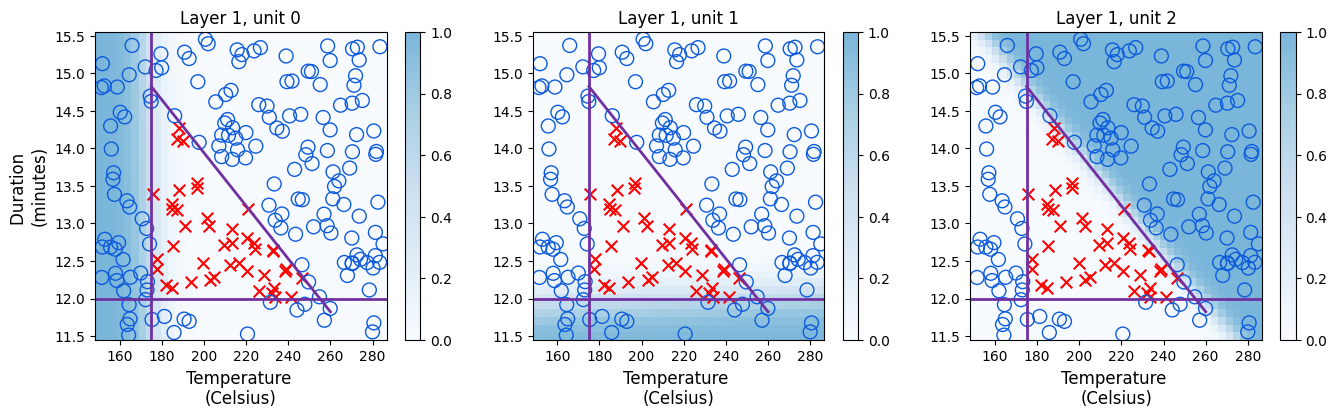

In [32]:
plt_layer(X,Y.reshape(-1,),W1,b1,norm_l)

> The shading shows that each unit is responsible for a different "bad roast" region. unit 0 has larger values when the temperature is too low. unit 1 has larger values when the duration is too short and unit 2 has larger values for bad combinations of time/temp. It is worth noting that the network learned these functions on its own through the process of gradient descent. They are very much the same sort of functions a person might choose to make the same decisions.

> The function plot of the final layer is a bit more difficult to visualize. It's inputs are the output of the first layer. We know that the first layer uses sigmoids so their output range is between zero and one. We can create a 3-D plot that calculates the output for all possible combinations of the three inputs. This is shown below. Above, high output values correspond to 'bad roast' area's. Below, the maximum output is in area's where the three inputs are small values corresponding to 'good roast' area's.

<ipython-input-3-956e3019b8a7>:106: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d[i,j,k] = keras.activations.sigmoid(np.dot(v,W[:,0])+b).numpy()


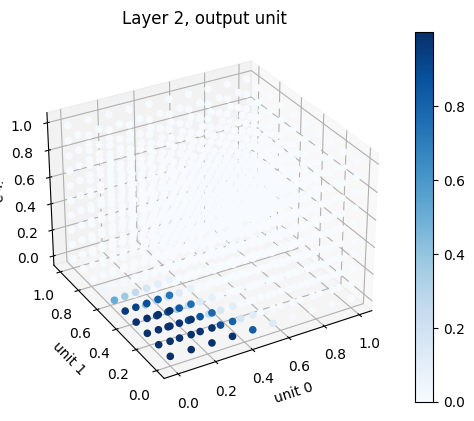

In [33]:
plt_output_unit(W2,b2)

> The final graph shows the whole network in action.
The left graph is the raw output of the final layer represented by the blue shading. This is overlaid on the training data represented by the X's and O's.

>The right graph is the output of the network after a decision threshold. The X's and O's here correspond to decisions made by the network.

The following takes a moment to run

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


<ipython-input-3-956e3019b8a7>:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  z[i,j] = fwb(x)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

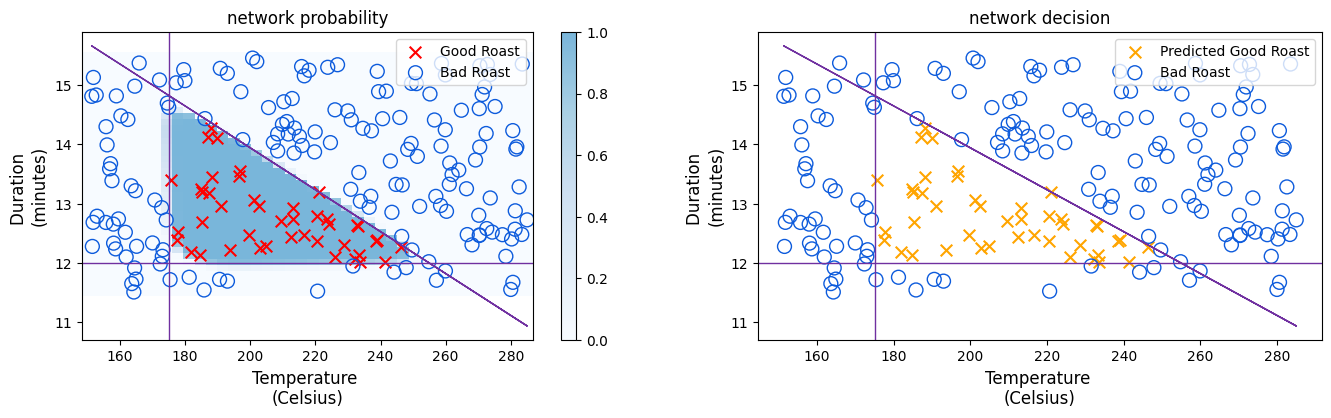

In [34]:
netf= lambda x : model.predict(norm_l(x))
plt_network(X,Y,netf)

One more implementation:

# scikit-learn

>In scikit-learn, neural networks are implemented in the `MLPClassifier` and `MLPRegressor` classes.


> To create this neural network in scikit-learn, you can follow these steps:

- Import the MLPClassifier or MLPRegressor class from the sklearn.neural_network module.
- Create an instance of the class and specify the parameters of the model. The most important parameters are the number of hidden layers, the number of neurons in each hidden layer, and the activation function.
- Fit the model to the training data.
- Use the model to predict the labels of new data.

In [35]:
# Create an instance of the MLPClassifier class
neural_network = sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(3), activation='logistic')
 # Fit the model to the training data
neural_network.fit(Xt,Yt)
y_pred_prob = neural_network.predict_proba(X_testn)
# Predict the labels of new data
y_pred = neural_network.predict(X_testn)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1105: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [36]:
y_pred

array([1., 0.])